In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
arch = 'resnet50'
model_file = f'{arch}_places365.pth.tar'
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
model.eval()
for param in model.parameters():
    param.requires_grad = False
'convert model to evaluation mode with no grad'

'convert model to evaluation mode with no grad'

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
feature_extractor = nn.Sequential(*list(model.children())[:-2], nn.AdaptiveAvgPool2d(1)).eval().to(device)

In [0]:
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/resized_imgs.pkl  /content/
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/masks.pkl  /content/
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/classes.pkl  /content/

In [0]:
import pickle
with open('masks.pkl', 'rb') as f:
  masks = pickle.load(f)
with open('resized_imgs.pkl', 'rb') as f:
  imgs = pickle.load(f)
with open('classes.pkl', 'rb') as f:
  labels = np.array(pickle.load(f))

In [0]:
def get_segments(img, mask, threshold = 0.05):
  segs = np.unique(mask)
  segments = []
  total = mask.shape[0]*mask.shape[1]
  for seg in segs:
    idxs = mask==seg
    sz = np.sum(idxs)
    if sz < threshold*total:
      continue
    segment = img*idxs[..., None]
    w, h, _ = np.nonzero(segment)
    segment = segment[np.min(w):np.max(w),np.min(h):np.max(h),:]
    segments.append(segment)
  return segments

In [0]:
img_segments = []
for img, msk in zip(imgs, masks):
  img_segments.append(get_segments(np.array(img), msk, threshold = 0.005))

In [0]:
del masks

In [0]:
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        # trn.Normalize([0, 0, 0], [255, 255, 225]),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
feature_vectors = []
all_vectors = []
for img_seg in img_segments:
    vectors = []
    for seg in img_seg:
      img = Image.fromarray(seg, 'RGB')
      input_img = V(centre_crop(img).unsqueeze(0))
      input_img = input_img.to(device)
      feature_tensor = feature_extractor.forward(input_img)
      del input_img
      feat_vec = feature_tensor.cpu().numpy().squeeze()
      del feature_tensor
      vectors.append(feat_vec)
      all_vectors.append(feat_vec)
    feature_vectors.append(vectors)

In [0]:
del img_segments

In [0]:
segment_img = {}
c = 0
for j, fvec in enumerate(feature_vectors): 
  c_old = c
  c += len(fvec) if len(fvec) != 1024 else 1
  for i in range(c_old, c):
    segment_img[i] = j

In [0]:
del feature_vectors

In [0]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [0]:
def cluster_top_k(cluster_id, k = 40):
  instances_ids = np.argwhere(clusters_labels==cluster_id).squeeze()
  instances = X[instances_ids]
  scores = []
  for inst in instances:
    scores.append(-kmeans.score([inst]))
  final_ids = np.argsort(scores)[:k]
  return instances_ids[final_ids]

cluster_instances_id = lambda cid:  np.argwhere(clusters_labels==cid).squeeze()

def is_single_img_clusters(cls_id):
  instances_ids = cluster_instances_id(cls_id)
  # instances_ids = cluster_representatives[cls_id]
  source_imgs = [segment_img[inst_id] for inst_id in instances_ids]
  unique_imgs = len(np.unique(source_imgs))
  return 0 if unique_imgs > 1 else 1

In [0]:
X = np.array(all_vectors)
num_segs = X.shape[0]
k = int(num_segs**0.5)
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
clusters_labels = kmeans.labels_

In [0]:
## calculating importances
cluster_names, cluster_counts = np.unique(clusters_labels, return_counts=1)
cluster_scores = []
for cls in cluster_names:
  cluster_scores.append(kmeans.score(X[np.argwhere(clusters_labels==cls).squeeze()]))
cluster_scores = np.array(cluster_scores)
cluster_importance = [cluster_counts, cluster_scores]

In [0]:
count_threshold = int(k*0.4)
ids = cluster_counts > count_threshold
good_clusters = cluster_names[ids]
for i in range(len(cluster_importance)):
  cluster_importance[i] = cluster_importance[i][ids]
print(f'total number of clusters {len(cluster_names)}')
print(f'total number of good clusters {len(good_clusters)}')

total number of clusters 108
total number of good clusters 104


In [0]:
final_clusters = []
for j, cluster_id in enumerate(good_clusters):
  if is_single_img_clusters(cluster_id):
    for i in range(len(cluster_importance)):
      cluster_importance[i] = np.delete(cluster_importance[i], j)
    continue
  final_clusters.append(cluster_id)
final_clusters = np.array(final_clusters)

In [0]:
cluster_representatives = {}
for cluster_id in final_clusters:
  cluster_representatives[cluster_id] = cluster_top_k(cluster_id, k=40)

In [0]:
linear_models = {}
model_score = {}
for cluster in final_clusters:
  positive_instances = cluster_instances_id(cluster)
  negative_instances = np.argwhere(clusters_labels!=cluster).squeeze()
  num_samples = min(len(positive_instances), len(negative_instances))
  selected_pos = np.random.choice(positive_instances, num_samples, replace=False)
  selected_neg = np.random.choice(negative_instances, num_samples, replace=False)
  train_x = np.append(X[selected_pos], X[selected_neg], axis=0)
  train_y = np.array([1] * num_samples + [0] * num_samples)
  train_x, val_x, train_y, val_y = train_test_split(train_x, train_y)
  n_components = min(256, len(train_x))
  pca_model = PCA(n_components=n_components)
  lr_model = LogisticRegression()
  pca_lr_model = Pipeline(steps = [('pca', pca_model), ('lr', lr_model)])
  # pca_lr_model.set_params(pca__n_components=256, lr__penalty='l2')
  pca_lr_model.fit(train_x, train_y)
  linear_models[cluster] = pca_lr_model
  model_score[cluster] = pca_lr_model.score(val_x, val_y)

In [0]:
!wget -q http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!wget -q http://data.csail.mit.edu/places/ADEchallenge/release_test.zip

In [0]:
!unzip -q ADEChallengeData2016.zip
!unzip -q release_test.zip

In [0]:
from DataLoader import ADE20KLoader
train_dataset = ADE20KLoader(root=os.getcwd(), split='train')
val_dataset = ADE20KLoader(root=os.getcwd(),split='val')
print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 20210
Validation images: 2000


In [0]:
# try also only the val set

In [0]:
chosen_classes = ['street', 'bedroom', 'living_room', 'bathroom', 'kitchen', 
            'skyscraper', 'highway', 'conference_room', 'mountain_snowy', 'office',
            'corridor', 'airport_terminal', 'attic', 'mountain', 'park', 'coast', 
            'alley','beach', 'childs_room', 'art_gallery','castle', 'dorm_room', 
            'nursery', 'lobby', 'reception', 'bar', 'house', 'bridge', 'classroom']
num_classes = len(chosen_classes)
num_classes

29

In [0]:
np.random.seed(0)
num_samples = 50
X_train = np.array([])
y_train = []
for cls in chosen_classes:
  ids = np.where(train_dataset.labels==cls)[0]
  ids = np.random.choice(ids, num_samples) if len(ids)>=50 else ids
  X_train = np.concatenate((X_train, ids)).astype(int)
  y_train += [cls]*len(ids)

In [0]:
print(len(X_train))
len(y_train)

1442


1442

In [0]:
# I can use batch size here to speed things up

In [0]:
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = np.array(classes)

In [0]:
idxs = []
c = 0
for ccls in chosen_classes:
  idx = np.argwhere(classes == ccls)
  if len(idx) == 0:
    print(f'class {ccls} is not found in places365, so we will use places365 alternate')
    c+=1
  else:
    idxs.append(idx[0][0])

In [0]:
outputs= []
def hook(module, input, output):
    x = nn.AdaptiveAvgPool2d(1)(output)
    outputs.append(x.cpu().numpy().squeeze())
full_model = model
handle = full_model.layer4[2].register_forward_hook(hook)
full_model.to(device)
'finished the full model with hook attached'

'finished the full model with hook attached'

In [0]:
del outputs
outputs = []
y_model = []
for idx in X_train:
  img = train_dataset[idx]
  input_img = V(centre_crop(img).unsqueeze(0))
  input_img = input_img.to(device)
  pred = full_model.forward(input_img)
  y_model.append(classes[idxs][np.argmax((pred.cpu().detach().numpy()[:,idxs]))])
outputs = np.array(outputs)

In [0]:
outputs.shape

(1442, 2048)

In [0]:
for k, v in model_score.items():
  if v < 0.75:
    print(f'removed cluster {k}')
    linear_models.pop(k, 'None')
    model_score.pop(k, 'None')
    for i in range(len(cluster_importance)):
      cluster_importance[i] = np.delete(cluster_importance[i],
                                        np.argwhere(final_clusters==k)[0][0])

In [0]:
for i, lm in enumerate(linear_models.keys()):
  if i == 0:
    concept_vecs = linear_models[lm].predict(outputs)[:, None]
  else:
    concept_vecs = np.concatenate((concept_vecs, linear_models[lm].predict(outputs)[:, None]), axis = -1)

In [0]:
concept_vecs.shape

(1442, 104)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
random_seed = 0

In [0]:
cluster_importance.append(cluster_importance[1]/cluster_importance[0])

In [0]:
# random_seed = np.random.randint(99999999)
random_seed = 0
steps = np.arange(1,len(linear_models)+1,1)
ii = -1
all_train_accs = []
all_test_accs = []
for _ in range(2):
  ii *= -1
  new_concept_vecs = concept_vecs[:, np.argsort(cluster_importance[2])[::ii]]
  # print(np.argsort(cluster_importance[2])[:])
  train_accs = []
  test_accs = []
  for step in steps:
    train_x, val_x, train_y, val_y = train_test_split(new_concept_vecs[:, :step], y_model, test_size=0.2, random_state=random_seed)
    surrogate_tree = DecisionTreeClassifier(max_depth = 20, random_state=random_seed)
    surrogate_tree.fit(train_x, train_y)
    train_accs.append(surrogate_tree.score(train_x, train_y))
    test_accs.append(surrogate_tree.score(val_x, val_y))
  all_train_accs.append(train_accs)
  all_test_accs.append(test_accs)

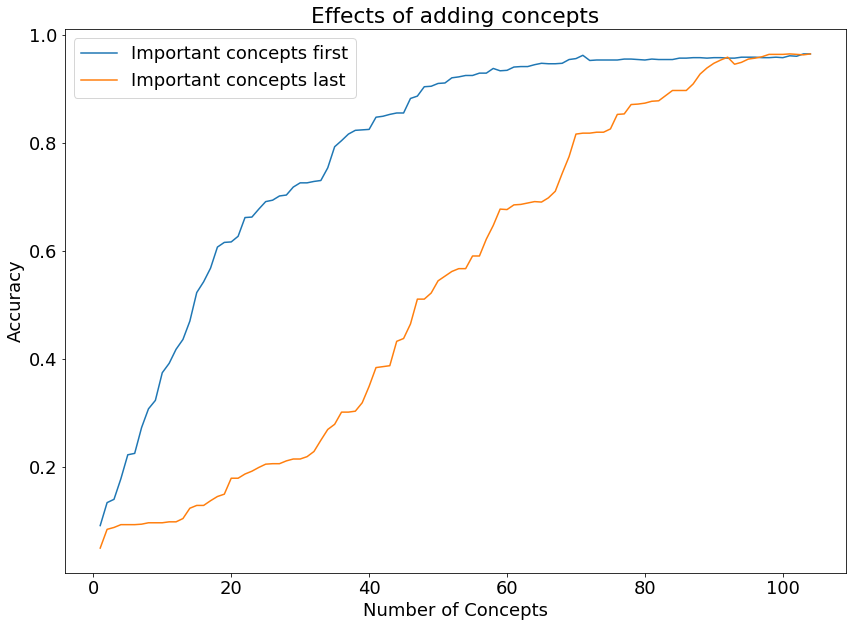

In [0]:
plt.figure(figsize=(14,10))
i = 0
for train_accs, test_accs in zip(all_train_accs, all_test_accs):
  plt.rcParams.update({'font.size': 18})
  plt.plot(steps, train_accs, '-',label = 'Important concepts first' if i == 0 else 'Important concepts last')
  # plt.plot(steps, test_accs, '-', label = 'test accuracy')
  plt.xlabel('Number of Concepts')
  plt.ylabel('Accuracy')
  plt.title('Effects of adding concepts')
  # plt.xticks(depths)
  # plt.yticks(np.arange(0,1,0.15))
  plt.legend()
  i+=1
plt.show()

In [0]:
# random_seed = np.random.randint(99999999)
# Here I am removing from the end of the feature vectors so ii is initialized as 1 not -1
random_seed = 0
steps = np.arange(1,len(linear_models)+1,1)
ii = 1
all_train_accs = []
all_test_accs = []
for cls_imp in cluster_importance[:2]:
  ii *= -1
  new_concept_vecs = concept_vecs[:, np.argsort(cluster_importance[2])[::ii]]
  # print(np.argsort(cluster_importance[2])[:])
  train_accs = []
  test_accs = []
  for step in steps[::-1]:
    train_x, val_x, train_y, val_y = train_test_split(new_concept_vecs[:, :step], y_model, test_size=0.2, random_state=random_seed)
    surrogate_tree = DecisionTreeClassifier(max_depth = 20, random_state=random_seed)
    surrogate_tree.fit(train_x, train_y)
    train_accs.append(surrogate_tree.score(train_x, train_y))
    test_accs.append(surrogate_tree.score(val_x, val_y))
  all_train_accs.append(train_accs)
  all_test_accs.append(test_accs)

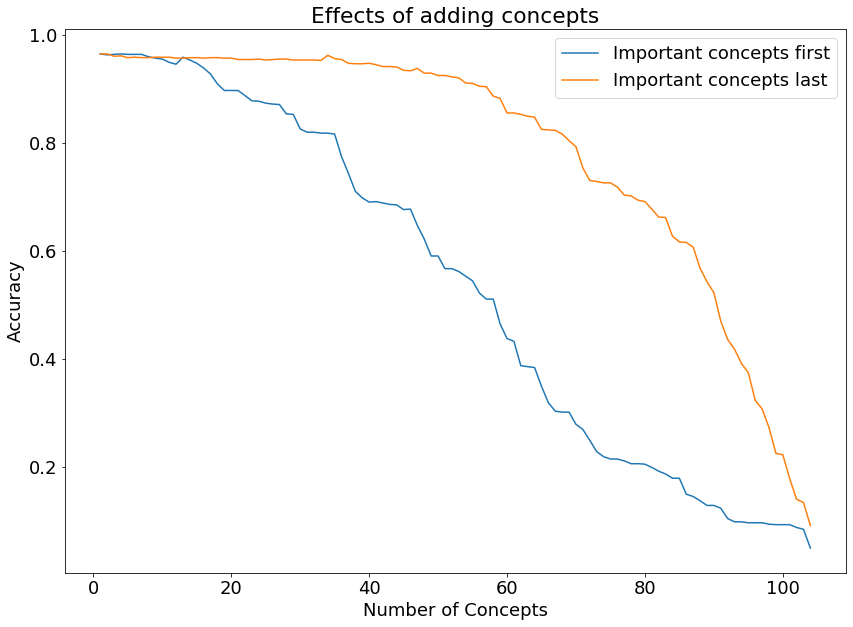

In [0]:
plt.figure(figsize=(14,10))
i = 0
for train_accs, test_accs in zip(all_train_accs, all_test_accs):
  plt.rcParams.update({'font.size': 18})
  plt.plot(steps, train_accs, '-',label = 'Important concepts first' if i == 0 else 'Important concepts last')
  # plt.plot(steps, test_accs, '-', label = 'test accuracy')
  plt.xlabel('Number of Concepts')
  plt.ylabel('Accuracy')
  plt.title('Effects of adding concepts')
  # plt.xticks(depths)
  # plt.yticks(np.arange(0,1,0.15))
  plt.legend()
  i+=1
plt.show()